## Домашнее здание №2 / Link Prediction

### Яронская Любовь / 394

----
План выполнения домашнего задания:

1. Краткий обзор исходных данных
2. Генерация дополнительных данных
3. Создание матрицы признаков для ребер
4. Настройка модели и валидация качества модели
5. Отправка результатов в контест на Kaggle

----

В данном домашнем задании вам предстоит построить классификатор, который бы предсказывал наличие или отсутствия ребра в графе между двумя вершинами. Никакой дополнительной информации о вершинах, кроме ее соседей нет, поэтому вам придется создавать вектор признаков для каждой пары вершин на основе топологии графа.

Вершины графа - товары интернет магазина, наличие ребра символизируют о высокой частоте совместной покупки данных товаров вместе. Например если в нашем графе присутствую вершины молоко и хлеб и данные товары часто покупаются вместе, то между данными вершинами будет ребро. Если в нашем графе есть вершины молоко и кроссовки, то между данными вершинами ребра не будет. 

В данном датасете уровень относительной частоты по которому решается есть ребро между вершинами или его нет был определен за нас. Сам датасет был получен краулингом сайта Amazon.com в марте 2003 года, парсилась секция "Люди которые купили данный продукт, также преобретали это..."

Мотивация данного задания: Расширить список блока рекомендаций, за счет товаров которые с высокой вероятность могут оказаться в одной корзине покупателя.

----
Для создания модели и работы с данными мы будем использовать пакет GraphLab, структуры данных SFrame и SGraph идеально подходят для работы с графами. Распределенное хранение данных и применения функций для расчета метрик отдельных вершин сильно облегчают работу с графом.

Библиотека платная, но лицензия для академических целей получается в течении 5 минут, чтобы установить пакет следуйте шагам на сайте - https://turi.com/download/academic.html

----

Описание файлов:

1. the_graph.csv - файл содержащий ребра графа, две колонки: src,dst 
2. suspicions.csv - файл с ребрами, графа. Для данных ребер неизвестно присутствует ли оно в графе или нет.

Описание целевой метрики - в качестве целевой метрики будем использовать ROC AUC http://mlwiki.org/index.php/ROC_Analysis

----

In [3]:
import graphlab as gl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from graphlab import degree_counting
import graphlab.aggregate as agg

gl.canvas.set_target('ipynb')

### 1. Краткий обзор исходных данных - 10 Баллов

Загрузим данные, найдем ряд базовых статистик:

1. Количество вершин и ребер
2. Распределение степеней вершин графа (График log - log)
3. Плотность графа
4. Диаметр графа
5. Количество треугольников в графе
6. Краткие выводы о данных.
7. БОНУСЫ - сделайте красивую визулизацию или расчет дополнительных метрик с выводами и вы получите дополнительные баллы за задание

In [4]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)

In [5]:
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

1. Количество вершин и ребер

In [6]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 1384871


Выполните пункты 2 - 6. В пункте 6 напишите краткие выводы.

    2. Распределение степеней

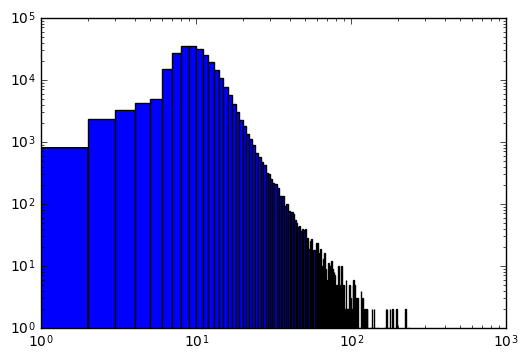

In [7]:
deg = degree_counting.create(g)
g = deg['graph']
degrees = g.vertices['total_degree']

plt.xscale('log')
plt.yscale('log')
plt.hist(degrees, bins=np.arange(degrees.min(), degrees.max()+1))

plt.show()

    3. Плотность графа

In [29]:
V = vert_edgs['num_vertices']
E = vert_edgs['num_edges']

print 'Density: {}'.format(2.*E/(V*(V-1)))

Density: 4.03153541186e-05


    4. Диаметр графа

In [30]:
from graphlab import shortest_path

sp = shortest_path.create(g, source_vid=123)
sp_sframe = sp['distance']
sp_graph = sp['graph']
path = sp.get_path('98')

+----------------------------+

| Number of vertices updated |

+----------------------------+

| 458                        |

| 28401                      |

| 269085                     |

| 199067                     |

| 52142                      |

| 8437                       |

| 817                        |

| 48                         |

| 3                          |

| 0                          |

+----------------------------+

ValueError: Destination vertex id 98 not found

    5. Количество треугольников

    6. Краткие выводы о данных

----
### 2. Генерация дополнительных данных - 20 Баллов

Перед нами стоит задача создания модели классификации, которая в дальнейшем будет использоваться для повышения разнообразия блока рекомендаций. Для большинства моделей классификации требуется минимум 2 класса объектов - негативный и позитивный. Но у нас есть только граф, ребра которые в нем присутствуют это позитивные примеры. Получается, что у нас нет негативных примеров. 

Ответьте на 3 вопроса:

1. Можем ли мы сами создать негативные примеры? Граф это описание связей между вершинами, если мы будем случайным образом выбирать две вершины и считать, что это ребро - негативный пример, имеет ли это смысл?
2. Если мы решим сгенерировать негативные примеры, как должна быть устроена процедура генерации, чтобы обобщаяющая способность модели была наилучшей?
3. Как зависит обобщающая способность модели от негативных примеров, которые мы ей покажем?

------
Создадим класс отрицательных примеров, сгенерировав его самым простым образом: берем две вершины, если ребро между ними отсутствует в графе, то это отрицательный пример.

1. Попробуйте улучшить генерацию отрицательных примеров

In [8]:
# read in existing edges
graph_file = open('the_graph.csv')
graph_file.readline() # first line is column names
existing_edges = set()

for x in graph_file:
    start, end = x.split(',')
    start, end = int(start), int(end)
    existing_edges.add((start, end))
    
print len(existing_edges)

1384871


In [9]:
# generating negative examples, so that class balance is 50/50 
generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    end = np.random.randint(0, vert_edgs['num_vertices'])
    
    if (start != end) & ((start, end) not in existing_edges):
        generated_nonexisting_edges.append([start, end, 0])
        
    counter += 1
    if counter == vert_edgs['num_edges']:
        break

print len(generated_nonexisting_edges)

1384839


In [10]:
# create SFrame with negative examples
generated_nonexisting_edges = pd.DataFrame(data=generated_nonexisting_edges, columns=['src', 'dst', 'class'])
generated_nonexisting_edges = gl.SFrame(data=generated_nonexisting_edges)

In [11]:
# add target function to the original dataset 
edges['class'] = [1]*edges.shape[0]

In [12]:
# add negative examples to the main data and shuffle
edges = edges.append(generated_nonexisting_edges)
edges = gl.cross_validation.shuffle(edges)

In [13]:
# update our graph g with fake edges
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

In [14]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 2769710


----
### 3. Создание матрицы признаков для ребер - 30 Баллов

Для создания модели классификации нам необходимы признаки, которые описывают каждое ребро. Вот базовый список того, что можно посчитать:

Для вершин:

1. Список и количество вершин, из которых ребра приходят в данную вершину
2. Список и количество вершин, в которые ребра приходят из данной вершины
3. Список и количество вершин связанных с данной вершиной
4. Список и количество вершин, которые связанны с данной вершиной как входящими, так и исходящими ребрами

Также можно добавить: вершины с которыми данная вершина образует треугольники, кластеризовать вершины и использовать кластер данной вершины и др.

Придумайте дополнительные интересные признаки для вершин и вы получите дополнительный балл за домашнюю работу!

In [15]:
all_vertices = g.get_vertices()
all_vertices.rename({"__id": "id"}) 
all_vertices.head(3)

id
5
7
8


In [16]:
# calculating each vertices in and out connections
out_vertices = edges.groupby("src", {"out_vertices": gl.aggregate.CONCAT("dst")})
out_vertices.rename({"src": "id"})

in_vertices = edges.groupby("dst", {"in_vertices": gl.aggregate.CONCAT("src")})
in_vertices.rename({"dst": "id"})
print 

In [17]:
# join in and out connections with all_vertices
all_vertices = all_vertices.join(out_vertices, on="id", how="outer")
all_vertices = all_vertices.join(in_vertices, on="id", how="outer")

# replace missing values with empty lists
all_vertices = all_vertices.fillna('in_vertices',[])
all_vertices = all_vertices.fillna('out_vertices',[])
all_vertices.head(3)

id,out_vertices,in_vertices
211023,"[57637, 158723, 159269,167594, 254497, 42873, ...","[248527, 62611, 20201,196887, 209072, 233626, ..."
79732,"[52416, 79734, 84908,207839, 211508, 170941, ...","[59638, 177610, 138065,103248, 95872, 156391, ..."
7899,"[196207, 55715, 63347,27312, 7896, 257163, ...","[6150, 8977, 15258,27312, 193079, 7898, ..."


Мы получили базовый набор данных - список входящих и исходящих вершин, для каждой вершины. Теперь найдем количества вершин для метрик 1 и 2. Метрики 3 и 4 вы посчитаете сами

In [18]:
# in_degree - number of users following each vertex
all_vertices['in_degree'] = all_vertices["in_vertices"].apply(lambda x: len(x) )

# out_degree - number of users each vertex is following
all_vertices['out_degree'] = all_vertices["out_vertices"].apply(lambda x: len(x) )

In [19]:
all_vertices.head(3)

id,out_vertices,in_vertices,in_degree,out_degree
211023,"[57637, 158723, 159269,167594, 254497, 42873, ...","[248527, 62611, 20201,196887, 209072, 233626, ...",12,18
79732,"[52416, 79734, 84908,207839, 211508, 170941, ...","[59638, 177610, 138065,103248, 95872, 156391, ...",19,13
7899,"[196207, 55715, 63347,27312, 7896, 257163, ...","[6150, 8977, 15258,27312, 193079, 7898, ...",9,12


Мы получили характеристики для каждой вершины графа. Так как у нас задача предсказания наличия ребра, мы должны составить описание каждого ребра, используя метрики вершин. После составления характеристик ребер, мы можем перейти к генерации свойств ребер, взяв за основу метрики вершин ребра. Пример метрик для ребер, которые мы можем найти:

1. Общие друзья вершин ребра
2. Общее количество друзей вершин ребра
3. Коэффициенты Жаккара, Пирсона, Адамик - Адара, косинусная мера

Данные метрики находятся для каждого списка вершин, пунктов 1 - 4

In [20]:
all_vertices

id,out_vertices,in_vertices,in_degree,out_degree
211023,"[57637, 158723, 159269,167594, 254497, 42873, ...","[248527, 62611, 20201,196887, 209072, 233626, ...",12,18
79732,"[52416, 79734, 84908,207839, 211508, 170941, ...","[59638, 177610, 138065,103248, 95872, 156391, ...",19,13
7899,"[196207, 55715, 63347,27312, 7896, 257163, ...","[6150, 8977, 15258,27312, 193079, 7898, ...",9,12
25263,"[76741, 249001, 6963,49299, 32701, 6965, 6 ...","[38607, 174885, 42349,111709, 6965, 85933] ...",6,9
87629,"[200493, 4221, 238810,2185, 6873, 215835, ...","[76237, 127102, 183942,127101, 150527, 78690, ...",23,11
43116,"[227750, 50536, 115968,43114, 50535, 43113, ...","[43114, 43117, 125134,43113, 50535, 246688, ...",14,10
144280,"[25249, 152258, 32373,152259, 240913, 22436, ...","[152259, 68011, 87269,124943, 156229, 152258, ...",7,9
238256,"[140495, 54402, 233160,232100, 249606, 175756] ...","[176171, 75978, 223179,233160, 232100, 249606] ...",6,6
62361,"[128106, 130685, 70918,70919, 70917, 62359, ...","[159136, 38016, 70919,111341, 62359, 251016, ...",22,10
5288,"[5468, 7373, 239354,2769, 60055, 3077, ...","[1642, 106525, 197361,144609, 74947, 5291, ...",22,10


In [21]:
edges = edges.join(all_vertices, on={"src": "id"}, how="right")
edges.rename({"in_vertices": "src_in_vertices", "out_vertices": "src_out_vertices",
                  "in_degree": "src_in_degree", "out_degree": "src_out_degree"
                 })

edges = edges.join(all_vertices, on={"dst": "id"}, how="right")
edges.rename({"in_vertices": "dst_in_vertices", "out_vertices": "dst_out_vertices",
                  "in_degree": "dst_in_degree", "out_degree": "dst_out_degree"})

edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_degree	int
	src_out_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in_degree	int
	dst_out_degree	int

Rows: 3

Data:
+-------+--------+-------+-------------------------------+
|  src  |  dst   | class |        src_out_vertices       |
+-------+--------+-------+-------------------------------+
| 85973 | 222440 |   0   | [222440, 105278, 108242, 7... |
| 65105 | 83877  |   1   | [83877, 203461, 124123, 12... |
| 55484 | 109560 |   0   | [109560, 65184, 33504, 651... |
+-------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+
|        src_in_vertices        | src_in_degree | src_out_degree |
+-------------------------------+---------------+----------------+
| [78600, 91407, 60491, 2091... |       11      |       12       |
| [118109, 242685, 98498, 85... |       13      |       10       |
| [128052, 153511, 225256, 6... |       9       |       7        |
+-------------------------------+---------------+----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [206313, 59295, 222439, 21... | [85973, 186099, 219790, 26... |       9       |
| [67268, 139453, 85386, 101... | [65105, 98498, 240944, 802... |       10      |
| [109558, 121728, 83294, 84... | [55484, 229476, 208893, 84... |       18      |
+-------------------------------+-------------------------------+---------------+
+----------------+
| dst_out_degree |
+----------------+
|       8        |
|       12       |
|       16       |
+----------------+
[3 rows x 11 columns]

Найдем пункт 1 - общих друзей для списков вершин из пункта 1. Пункты 2 и 3 вы посчитаете самостоятельно

In [22]:
def common_friends(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return len(u_neighbors & v_neighbors)

In [23]:
edges['common_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'],x['src_in_vertices'], x['dst_in_vertices'])))

In [24]:
edges['common_out_vertices'] = (edges[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'],x['src_out_vertices'], x['dst_out_vertices'])))

Результатом пункта 3 является матрица признаков. Теперь мы готовы занятся настройкой моделей. Главная ваша задача в пункте 3 - подготовить как можно больше качественных признаков, которые могли бы использоваться для настройки модели машинного обучения.

----
### 4. Настройка модели и валидация качества модели - 20 Баллов

Исключим подозрительные ребра из рассмотрения, а затем разобьем датасет на 2 части, для обучения и проверки результатов. Настроим базовую модель классификации - логистическую регрессию.
Для улучшения качества модели вам предстоит выполнить следующие пункты:

1. Кросс - валидация для настройки гиперпараметров модели и регуляризации
2. Подбор модели машинного обучения (случайный лес, бустинг, нейронная сеть и т.д.)

In [25]:
susp = gl.SFrame.read_csv('suspicions.csv', delimiter=',', verbose=False)
print susp.shape

(299994, 3)


In [26]:
print edges.shape
edges = edges.join(susp, on=['src', 'dst'], how='left')
print edges.shape

(2769710, 13)
(2769710, 14)


In [27]:
clean_edges = edges[edges['edge_id'] == None]
susp_edges = edges[edges['edge_id'] != None]
print clean_edges.shape, susp_edges.shape

(2469716, 14) (299994, 14)


In [28]:
clean_edges.remove_column('edge_id')
print

In [29]:
clean_edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_degree	int
	src_out_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in_degree	int
	dst_out_degree	int
	common_in_vertices	int
	common_out_vertices	int

Rows: 3

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 85973  | 222440 |   0   | [222440, 105278, 108242, 7... |
| 55484  | 109560 |   0   | [109560, 65184, 33504, 651... |
| 133280 | 201142 |   0   | [201142, 91447, 97429, 498... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+
|        src_in_vertices        | src_in_degree | src_out_degree |
+-------------------------------+---------------+----------------+
| [78600, 91407, 60491, 2091... |       11      |       12       |
| [128052, 153511, 225256, 6... |       9       |       7        |
| [91446, 133281, 258312, 48... |       11      |       13       |
+-------------------------------+---------------+----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [206313, 59295, 222439, 21... | [85973, 186099, 219790, 26... |       9       |
| [109558, 121728, 83294, 84... | [55484, 229476, 208893, 84... |       18      |
| [247702, 180725, 163054, 7... | [149672, 133280, 202797, 2... |       13      |
+-------------------------------+-------------------------------+---------------+
+----------------+--------------------+---------------------+
| dst_out_degree | common_in_vertices | common_out_vertices |
+----------------+--------------------+---------------------+
|       8        |         0          |          0          |
|       16       |         0          |          0          |
|       12       |         0          |          0          |
+----------------+--------------------+---------------------+
[3 rows x 13 columns]

In [30]:
# split on train and test
test, train = clean_edges.random_split(0.2)

In [31]:
print test.shape, train.shape

(494592, 13) (1975124, 13)


In [ ]:
# fit basic classification model - LR
model = gl.classifier.logistic_classifier.create(train, 
                                                 target="class", 
                                                 features=[x for x in clean_edges.column_names() if 'class' not in x])
results = model.evaluate(test)
print results

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 1876653

Number of classes           : 2

Number of feature columns   : 12

Number of unpacked features : 12

Number of coefficients    : 1048423

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 4        | 0.000000  | 20.553563    | 0.625115          | 0.611114            |

| 2         | 6        | 1.000000  | 27.762031    | 0.769912          | 0.697281            |

| 3         | 7        | 1.000000  | 32.186057    | 0.798637          | 0.710636            |

| 4         | 8        | 1.000000  | 36.626125    | 0.844066          | 0.743031            |

Мы получили базовую модель с метриками: точность ~ 0.67, ROC AUC ~ 0.71. Ваша задача улучшить модель,  за счет добавления новых признаков вершин, ребер и аккуратного обучения выбранных моделей (настройки гиперпараметров и регуляризации).

----
### 5. Отправка результатов в контест на Kaggle - 20 Баллов


Завершая домашнюю работу, нам небходимо предсказать вероятности наличия ребер, для заданного списка ребер. Результат отправлется в контест на kaggle.com в формате: edge_id - probability

In [34]:
predicted = model.predict(susp_edges, output_type='probability')

ToolkitError: probability is not a valid option for output_type.  Expected one of: class, margin

In [32]:
susp_edges['probability'] = predicted

In [33]:
result = susp_edges['edge_id', 'probability']

In [34]:
result.save('result93.csv', format='csv')

----

----
### Не модифицируйте данный код, он для проверки вашего ноутбука

In [35]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# %matplotlib inline

In [36]:
# labeled = pd.read_csv('labeled_suspicions.csv')
# print labeled.shape

# res = labeled.merge(result.to_dataframe(), on='edge_id', how='inner')
# res = res[['class', 'probability']]
# print res.shape

In [37]:
# fpr, tpr, _ = roc_curve(res['class'], res['probability'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(15, 10))
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()